# TD(0) Algorithm Implementation with Visualizations

This notebook implements the TD(0) algorithm for Temporal Difference learning in a GridWorld environment. It includes visualizations for the environment, value function heatmaps, and learning curves.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation
from IPython.display import HTML

%matplotlib inline

## 1. GridWorld Environment

We define a simple 5x5 GridWorld environment. 
- **Start State**: (0, 0)
- **Goal State**: (4, 4)
- **Obstacles**: Defined manually
- **Actions**: Up, Down, Left, Right
- **Rewards**: +10 at Goal, -1 per step otherwise (to encourage shortest path).

In [2]:
class GridWorld:
    def __init__(self, size=5):
        self.size = size
        self.state = (0, 0)
        self.goal = (size-1, size-1)
        self.obstacles = [(1, 1), (2, 2), (3, 3), (1, 3)]
        self.actions = [(0, 1), (0, -1), (1, 0), (-1, 0)] # Right, Left, Down, Up
        self.action_names = ['Right', 'Left', 'Down', 'Up']

    def reset(self):
        self.state = (0, 0)
        return self.state

    def step(self, action_idx):
        action = self.actions[action_idx]
        next_state = (self.state[0] + action[0], self.state[1] + action[1])

        # Check boundaries
        if next_state[0] < 0 or next_state[0] >= self.size or \
           next_state[1] < 0 or next_state[1] >= self.size:
            next_state = self.state
        
        # Check obstacles
        if next_state in self.obstacles:
            next_state = self.state

        self.state = next_state
        
        reward = -1
        done = False
        if self.state == self.goal:
            reward = 10
            done = True
        
        return next_state, reward, done

    def get_all_states(self):
        states = []
        for i in range(self.size):
            for j in range(self.size):
                if (i, j) not in self.obstacles:
                    states.append((i, j))
        return states

## 2. Visualization Helper Functions

In [3]:
def plot_grid(env, value_function=None, title="GridWorld"):
    grid = np.zeros((env.size, env.size))
    
    # Mark obstacles
    for obs in env.obstacles:
        grid[obs] = -1
    
    plt.figure(figsize=(6, 6))
    
    if value_function is not None:
        # Fill grid with values
        val_grid = np.full((env.size, env.size), np.nan)
        for i in range(env.size):
            for j in range(env.size):
                if (i, j) not in env.obstacles:
                    val_grid[i, j] = value_function.get((i, j), 0)
        
        sns.heatmap(val_grid, annot=True, fmt=".2f", cmap="viridis", cbar=True, mask=np.isnan(val_grid))
    else:
        # Just show layout
        sns.heatmap(grid, annot=False, cbar=False, cmap="Greys", vmin=-1, vmax=0)
        
        # Annotate Start and Goal
        plt.text(0.5, 0.5, 'S', ha='center', va='center', color='green', fontsize=20, fontweight='bold')
        plt.text(env.size-0.5, env.size-0.5, 'G', ha='center', va='center', color='red', fontsize=20, fontweight='bold')
        
        # Annotate Obstacles
        for obs in env.obstacles:
            plt.text(obs[1]+0.5, obs[0]+0.5, 'X', ha='center', va='center', color='black', fontsize=20)

    plt.title(title)
    plt.show()

## 3. TD(0) Algorithm

The TD(0) update rule is:
$$ V(S) \leftarrow V(S) + \alpha [R + \gamma V(S') - V(S)] $$

In [4]:
def td_zero(env, num_episodes, alpha=0.1, gamma=0.9):
    # Initialize Value Function
    V = {state: 0 for state in env.get_all_states()}
    V[env.goal] = 0 # Terminal state value is 0 usually, but here we get reward on transition to it.
    # Actually, if we treat goal as terminal, V(goal) should be 0. 
    # The reward comes when entering the goal.
    
    # For visualization tracking
    value_history = []
    
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        
        while not done:
            # Random Policy: Choose random action
            action_idx = np.random.choice(len(env.actions))
            
            next_state, reward, done = env.step(action_idx)
            
            # TD Update
            current_val = V[state]
            next_val = V[next_state] if not done else 0
            
            td_target = reward + gamma * next_val
            td_error = td_target - current_val
            
            V[state] = current_val + alpha * td_error
            
            state = next_state
        
        # Store value function snapshot every few episodes
        if episode % 10 == 0:
            value_history.append(V.copy())
            
    return V, value_history

## 4. Running the Experiment

Environment Layout:


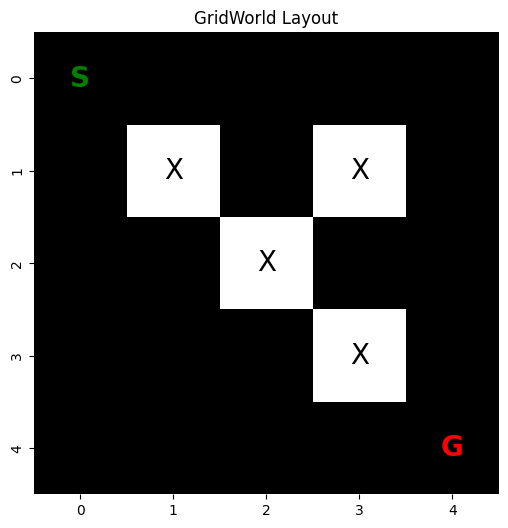

In [5]:
env = GridWorld()
print("Environment Layout:")
plot_grid(env, title="GridWorld Layout")

In [6]:
# Run TD(0)
num_episodes = 500
alpha = 0.1
gamma = 0.9

V_final, V_history = td_zero(env, num_episodes, alpha, gamma)

print(f"Training completed for {num_episodes} episodes.")

Training completed for 500 episodes.


## 5. Visualizing Results

Final Value Function Heatmap:


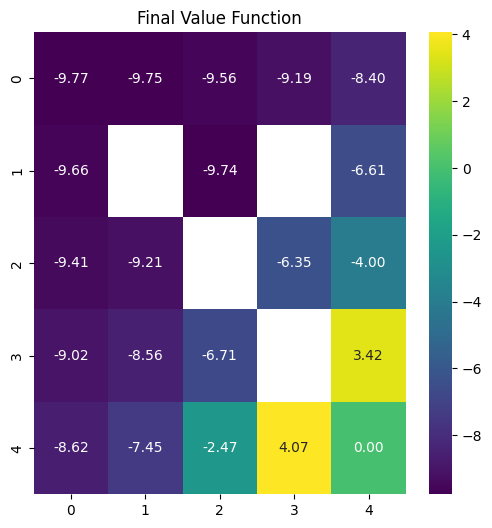

In [7]:
print("Final Value Function Heatmap:")
plot_grid(env, V_final, title="Final Value Function")

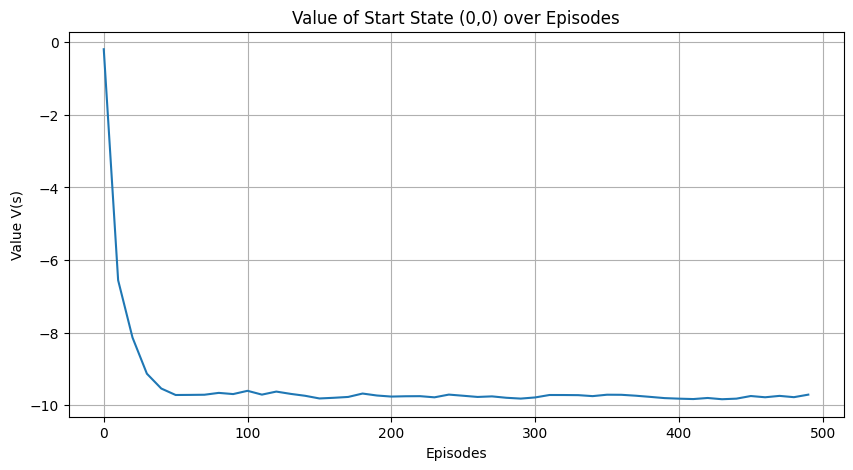

In [8]:
# Visualize Value Function Evolution for a specific state (e.g., Start State)
start_state_values = [v_hist[(0,0)] for v_hist in V_history]

plt.figure(figsize=(10, 5))
plt.plot(range(0, num_episodes, 10), start_state_values)
plt.title("Value of Start State (0,0) over Episodes")
plt.xlabel("Episodes")
plt.ylabel("Value V(s)")
plt.grid(True)
plt.show()